In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from IPython.display import display
from scipy import stats
from collections import OrderedDict
import celerite
from celerite import terms

### データの読み込み

In [2]:
train_ts = pd.read_csv("../data/input/training_set.csv")
display(train_ts.head())

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [3]:
train_meta = pd.read_csv("../data/input/training_set_metadata.csv")
display(train_meta.head())

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


### GPのテスト

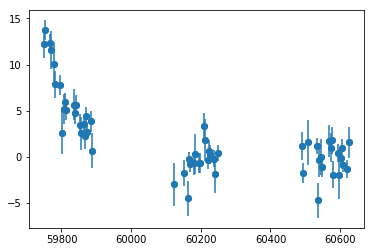

In [5]:
sample = train_ts.query('object_id == 23409 & passband == 2')
t = sample["mjd"]
y = sample["flux"]
y_err = sample["flux_err"]
plt.scatter(t, y)
plt.errorbar(t, y, y_err, fmt="o")
plt.show()

In [6]:
# A non-periodic component
rho = 1
sigma = np.var(y)
eps = 0.01
bounds = dict(log_sigema=(-100, 100), log_rhoa=(-5, 5), eps=(0.001, 1))
kernel = terms.Matern32Term(log_sigma=np.log(sigma), log_rho=np.log(rho), eps=eps,
                       bounds=bounds)

In [7]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, y_err)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

Initial log likelihood: -217.5767072883397
parameter_dict:
OrderedDict([('kernel:log_sigma', 2.80022632876468), ('kernel:log_rho', 0.0)])

parameter_names:
('kernel:log_sigma', 'kernel:log_rho')

parameter_vector:
[2.80022633 0.        ]

parameter_bounds:
[(None, None), (None, None)]



In [8]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="BFGS", args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)
print(gp.get_parameter_dict())

      fun: 116.91983219881368
 hess_inv: array([[0.10783441, 0.18603553],
       [0.18603553, 0.72128765]])
      jac: array([5.72204590e-06, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 17
     njev: 21
   status: 0
  success: True
        x: array([1.63667644, 5.58132107])
OrderedDict([('kernel:log_sigma', 1.6366764367995315), ('kernel:log_rho', 5.581321065252812)])


Text(0,0.5,'y')

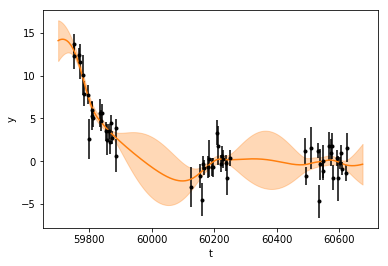

In [9]:
x = np.linspace(min(t)-50, max(t)+50, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.errorbar(t, y, yerr=y_err, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("t")
plt.ylabel("y")

予測が難しいobjectを例にフィッティングしてみる

In [15]:
object_id_list = train_meta.query("target in [42, 52, 62, 67, 90]").object_id.tolist()
target_list = train_meta.query("target in [42, 52, 62, 67, 90]").target.tolist()
len(object_id_list)

4381

730 42
OrderedDict([('kernel:log_sigma', 2.7840125904906463), ('kernel:log_rho', 4.7466152406114075)])


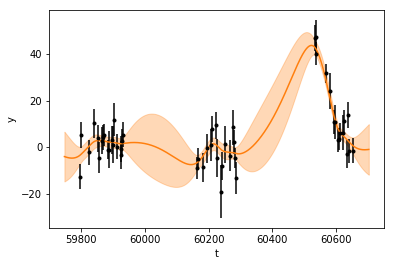

745 90
OrderedDict([('kernel:log_sigma', 3.8384529552462636), ('kernel:log_rho', 5.4976913553903515)])


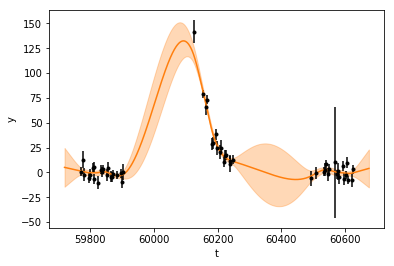

1124 90
OrderedDict([('kernel:log_sigma', 3.830210051963251), ('kernel:log_rho', 5.058853574113254)])


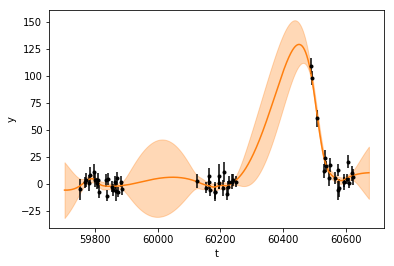

1598 90
OrderedDict([('kernel:log_sigma', 5.312841431182198), ('kernel:log_rho', 3.6546473696597848)])


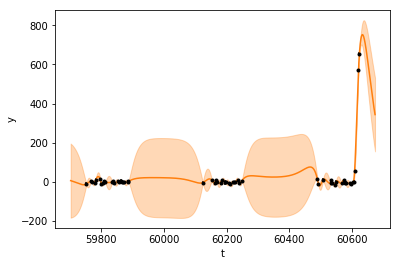

1632 42
OrderedDict([('kernel:log_sigma', -11.74993708334865), ('kernel:log_rho', 0.062189570274306334)])


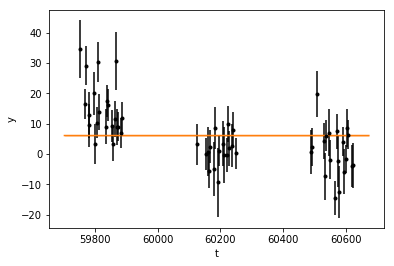

1920 90
OrderedDict([('kernel:log_sigma', 3.634603226401537), ('kernel:log_rho', 3.0257222460588364)])


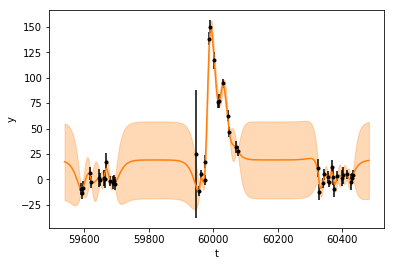

2072 90
OrderedDict([('kernel:log_sigma', 1.7740517170985786), ('kernel:log_rho', 10.274056481551181)])


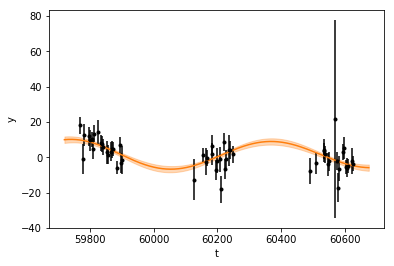

2103 42
OrderedDict([('kernel:log_sigma', 3.5088735383800134), ('kernel:log_rho', 3.074063541081589)])


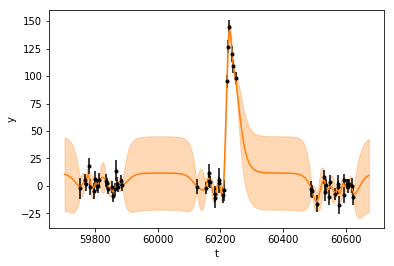

2300 42
OrderedDict([('kernel:log_sigma', 1.7744515282326918), ('kernel:log_rho', 5.3690103951188)])


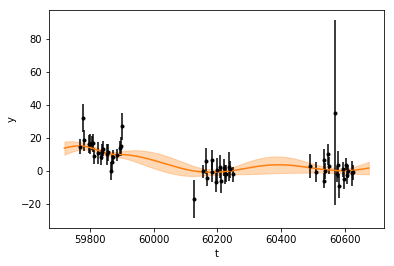

2330 90
OrderedDict([('kernel:log_sigma', -3.9608644790564265), ('kernel:log_rho', -4.643049332362714)])


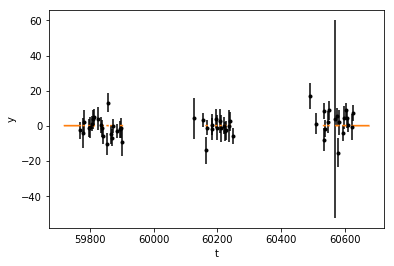

2922 67
OrderedDict([('kernel:log_sigma', 5.282652891773536), ('kernel:log_rho', 5.065846804406655)])


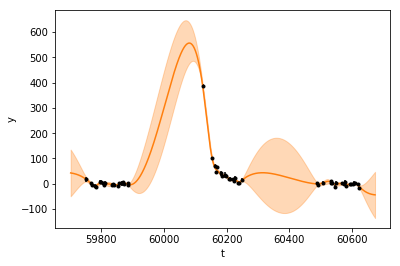

3041 67
OrderedDict([('kernel:log_sigma', -8.085833548054843), ('kernel:log_rho', 1.5439246474606618)])


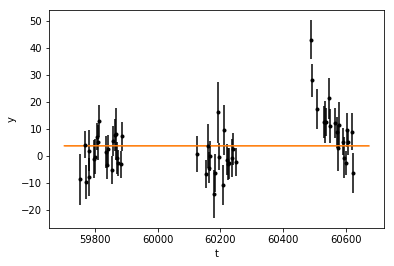

3285 42
OrderedDict([('kernel:log_sigma', 3.3959422641858255), ('kernel:log_rho', 3.2503509853181396)])


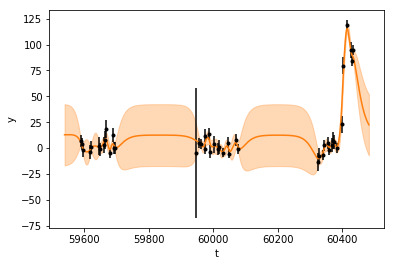

3910 62
OrderedDict([('kernel:log_sigma', 3.1714068863998883), ('kernel:log_rho', 2.0291843226266044)])


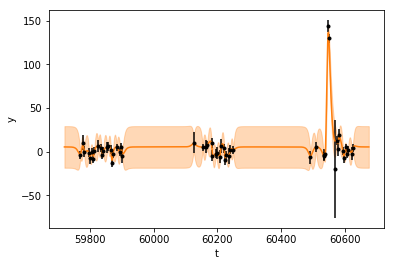

4132 42
OrderedDict([('kernel:log_sigma', 0.7417937791605321), ('kernel:log_rho', -1.228064174140114)])


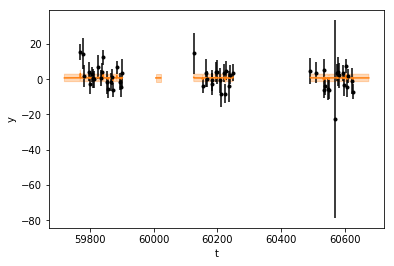

4220 42
OrderedDict([('kernel:log_sigma', 4.422881047228443), ('kernel:log_rho', 3.2001242430364147)])


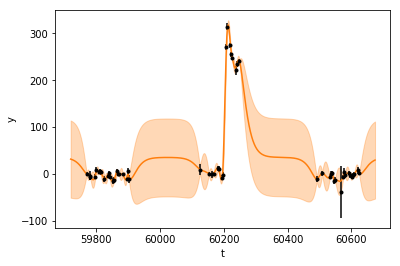

4389 90
OrderedDict([('kernel:log_sigma', 3.484544784671429), ('kernel:log_rho', 4.3192517284981315)])


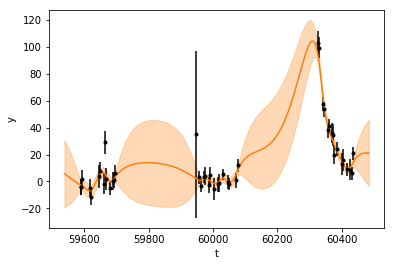

4595 90
OrderedDict([('kernel:log_sigma', 3.1978992811100917), ('kernel:log_rho', 3.211080551455059)])


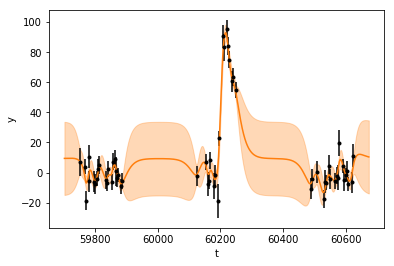

4819 90
OrderedDict([('kernel:log_sigma', 3.552753270080872), ('kernel:log_rho', 3.5840259527906526)])


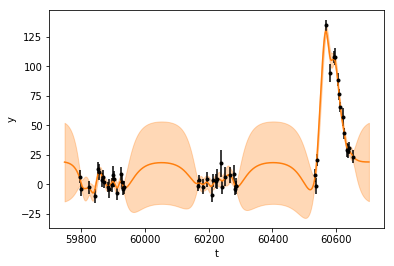

5527 42
OrderedDict([('kernel:log_sigma', 5.630845295125654), ('kernel:log_rho', 5.1771086864865845)])


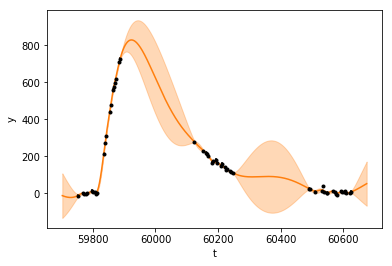

In [25]:
for i in range(20):
    object_id = object_id_list[i]
    target = target_list[i]

    extract_obj = train_ts.query("object_id == @object_id & passband == 5")
    t = extract_obj["mjd"]
    y = extract_obj["flux"]
    y_err = extract_obj["flux_err"]
    
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, y_err)

    # A non-periodic component
    rho = 1
    sigma = np.var(y)
    eps = 0.01
    bounds = dict(log_sigema=(-100, 100), log_rhoa=(-5, 5), eps=(0.001, 1))
    kernel = terms.Matern32Term(log_sigma=np.log(sigma), log_rho=np.log(rho), eps=eps,
                           bounds=bounds)
    
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    r = minimize(neg_log_like, initial_params, method="BFGS", args=(y, gp))
    
    print(object_id, target)
    print(gp.get_parameter_dict())

    x = np.linspace(min(t)-50, max(t)+50, 5000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    
    color = "#ff7f0e"
    plt.errorbar(t, y, yerr=y_err, fmt=".k", capsize=0)
    plt.plot(x, pred_mean, color=color)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                     edgecolor="none")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.show()

- http://dfm.io/george/dev/tutorials/first/

### スプライン補間

- https://arxiv.org/pdf/1504.00015.pdf
- http://iopscience.iop.org/article/10.3847/0067-0049/225/2/31/pdf  
- https://academic.oup.com/mnras/article/419/2/1121/988801

In [4]:
from scipy.interpolate import splprep, splev

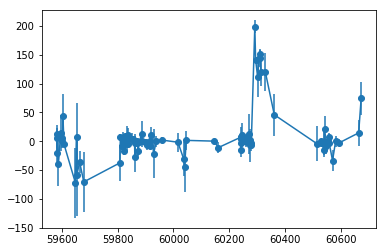

In [5]:
sample = train_ts.query('object_id == 35882729')
x = sample["mjd"]
y = sample["flux"]
y_err = sample["flux_err"]
plt.scatter(x, y)
plt.errorbar(x, y, y_err)
plt.show()

In [6]:
for object_id in train_ts.object_id.unique()[:30]:
    extract_obj = train_ts.query('object_id == @object_id')
    points = get_divided_point(extract_obj)
    print(object_id, points)
    bef_points = extract_obj['mjd'].min()

    for point in points:
        for passband in extract_obj.passband.unique():
            extract = extract_obj.query('mjd>=@bef_points & mjd<@point & passband==@passband')
            x = extract["mjd"]
            y = extract["flux"]
            y_err = extract["flux_err"]        
            plt.scatter(x, y)
            plt.errorbar(x, y, y_err, fmt='o')

            tck = splprep([x, y], k=2, w=1/y_err)[0]
            new_points = splev(np.arange(0, 1.01, 0.01), tck)
            #plt.scatter(x, y)
            plt.plot(new_points[0], new_points[1])

        bef_points = point
        plt.show()

NameError: name 'get_divided_point' is not defined

In [ ]:
from sklearn.cluster import KMeans
sample = train_ts.query('object_id == 15845')
diff_mjd = sample[["mjd"]].diff().dropna()
cluster_result = pd.Series(KMeans(n_clusters=2).fit_predict(diff_mjd), index=diff_mjd.index)
cluster_result.name = "cluster_mjd"
points = sample.join(cluster_result).query('cluster_mjd==1')['mjd'].values
points = np.concatenate([points, np.array([sample["mjd"].max()])])
print(points)

bef_points = sample['mjd'].min()
for point in points:
    for passband in sample.passband.unique():
        extract = sample.query('mjd>=@bef_points & mjd<@point & passband==@passband')
        x = extract["mjd"]
        y = extract["flux"]
        y_err = extract["flux_err"]
        plt.scatter(x, y)
        plt.errorbar(x, y, y_err, fmt='o')
        
        tck = splprep([x, y], k=3, w=1/y_err)[0]
        new_points = splev(np.arange(0, 1.01, 0.01), tck)
        #plt.scatter(x, y)
        plt.plot(new_points[0], new_points[1])
        plt.show()
    break
    
    bef_points = point

In [ ]:
import george
from george import kernels

In [ ]:
sample = train_ts.query('object_id == 4088 & passband == 5')
x = sample["mjd"].values[:21]
y = sample["flux"].values[:21]
y_err = sample["flux_err"].values[:21]
y = y - np.mean(y)
plt.scatter(x, y)
plt.errorbar(x, y, y_err)
plt.show()

In [ ]:
kernel = kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel, mean=np.mean(y), fit_mean=True)
gp.compute(x, y_err)
print(gp.lnlikelihood(y))

x_pred = np.linspace(min(x), max(x), 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=y_err, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")

In [ ]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_vector(p)
    return -gp.lnlikelihood(y)

def grad_neg_ln_like(p):
    gp.set_vector(p)
    return -gp.grad_lnlikelihood(y)

result = minimize(neg_ln_like, gp.get_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.lnlikelihood(y)))

### sncosmo

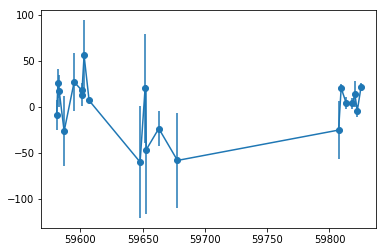

In [4]:
sample = train_ts.query('object_id == 35882729')
x = sample["mjd"].values[:21]
y = sample["flux"].values[:21]
y_err = sample["flux_err"].values[:21]
y = y - np.mean(y)
plt.scatter(x, y)
plt.errorbar(x, y, y_err)
plt.show()

In [5]:
import sncosmo
from astropy.table import Table

In [6]:
data = Table(
    {
        'time': sample.mjd.tolist(),
        'band': sample.passband.tolist(),
        'flux': sample.flux.tolist(),
        'flux_error': sample.flux_err.tolist(),
        'zp': np.zeros(len(sample)),
        'zpsys': np.zeros(len(sample))
    })

In [ ]:
model = sncosmo.Model(source='salt2')
# run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.3, 0.7)})  # bounds on parameters (if any

In [ ]:
sample = train_ts.query('object_id == 15845')
diff_mjd = sample[["mjd"]].diff().dropna()
cluster_result = pd.Series(KMeans(n_clusters=2).fit_predict(diff_mjd), index=diff_mjd.index)
cluster_result.name = "cluster_mjd"
points = sample.join(cluster_result).query('cluster_mjd==1')['mjd'].values
points = np.concatenate([points, np.array([sample["mjd"].max()])])
print(points)

In [ ]:
from sklearn.cluster import MiniBatchKMeans

def get_divided_point(obj_data):
    obj_data = obj_data.sort_values('mjd', ascending=True)
    diff_mjd = obj_data.groupby('object_id')[['mjd']].diff().dropna()

    # cluster
    def get_cluster(diff_mjd):
        km = MiniBatchKMeans(n_clusters=2)
        cluster_result = pd.Series(km.fit_predict(diff_mjd), index=diff_mjd.index)
        cluster_result.name = "cluster_mjd"

        # get points
        points = obj_data.join(cluster_result).query('cluster_mjd==1')['mjd'].values
        points = np.concatenate([points, np.array([obj_data["mjd"].max()])])
        
        return points
    
    points = np.zeros(100)
    while len(points) > 5:
        points = get_cluster(diff_mjd)
    
    return points

sample_data = train_ts.query('object_id == 35882729')
points = get_divided_point(sample_data)
print(points)

bef_points = sample_data['mjd'].min()
for point in points:
    extract = sample_data.query('mjd>=@bef_points & mjd<@point')
    plt.plot(extract.mjd, extract.flux, "o")
    bef_points = point

In [8]:
points

array([60118.4163, 60490.2647, 60624.2132])

In [15]:
points[min([i for i, point in enumerate(points) if point < sample_data.max()["mjd"]])]

60118.4163

[60118.4163 60490.2647 60624.2132]


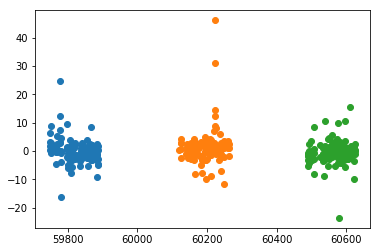

In [7]:
from sklearn.cluster import MiniBatchKMeans

def get_divided_point(obj_data):
    obj_data = obj_data.sort_values('mjd', ascending=True)
    diff_mjd = obj_data.groupby('object_id')[['mjd']].diff()

    # get points
    dist = 100
    points = obj_data[diff_mjd > dist]["mjd"].dropna().values
    points = np.concatenate([points, np.array([obj_data["mjd"].max()])])
      
    return points

sample_data = train_ts.query('object_id == 325372')
points = get_divided_point(sample_data)
print(points)

bef_points = sample_data['mjd'].min()
for point in points:
    extract = sample_data.query('mjd>=@bef_points & mjd<@point')
    plt.plot(extract.mjd, extract.flux, "o")
    bef_points = point

In [ ]:
for object_id in train_ts.object_id.unique()[:30]:
    extract_obj = train_ts.query('object_id == @object_id')
    points = get_divided_point(extract_obj)
    print(object_id, points)
    bef_points = extract_obj['mjd'].min()

    for point in points:
        for passband in extract_obj.passband.unique():
            extract = extract_obj.query('mjd>=@bef_points & mjd<@point & passband==@passband')
            x = extract["mjd"]
            y = extract["flux"]
            y_err = extract["flux_err"]        
            plt.scatter(x, y)
            plt.errorbar(x, y, y_err, fmt='o')

            kernel = ConstantKernel() * RBF()
            gp = GaussianProcessRegressor(kernel=kernel)
            gp.fit(x[:, np.newaxis], y)
            print(passband, gp.kernel_)

            X_ = np.linspace(min(x), max(x), 100)
            y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
            plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
            plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2)

        bef_points = point
        plt.show()

In [ ]:
result_list = []
for object_id in tqdm(train_ts.object_id.unique()):
    extract_obj = train_ts.query('object_id == @object_id')
    points = get_divided_point(extract_obj)
    bef_points = extract_obj['mjd'].min()

    for i, point in enumerate(points):
        for passband in extract_obj.passband.unique():
            extract = extract_obj.query('mjd>=@bef_points & mjd<@point & passband==@passband')
            x = extract["mjd"]
            y = extract["flux"]
            y_err = extract["flux_err"]        
            kernel = ConstantKernel() * RBF()
            gp = GaussianProcessRegressor(kernel=kernel)
            gp.fit(x[:, np.newaxis], y)
            result_list.append((object_id, i, passband, gp.kernel_.k1.constant_value, gp.kernel_.k2.length_scale))

        bef_points = point

In [ ]:
result = pd.DataFrame(result_list, columns=['object_id', 'i', 'passband', 'k1', 'k2'])
result = pd.merge(result, train_meta[["object_id", "target"]], on='object_id')
result = result.groupby(["object_id", "passband"]).max().reset_index()

In [ ]:
for pass_ in train_ts.passband.unique():
    result.query('passband==@pass_').boxplot(column=["k1"], by='target')

In [ ]:
for pass_ in train_ts.passband.unique():
    result.query('passband==@pass_').boxplot(column=["k2"], by='target')

In [ ]:
for object_id in train_ts.object_id.unique():
    extract_obj = train_ts.query('object_id == @object_id')
    points = points_dict[object_id]
    bef_points = extract_obj['mjd'].min()
    for point in points:
        for passband in extract_obj.passband.unique():
            extract = extract_obj.query('mjd>=@bef_points & mjd<@point & passband==@passband')
            x = extract["mjd"]
            y = extract["flux"]
            y_err = extract["flux_err"]
            plt.scatter(x, y)
            plt.errorbar(x, y, y_err, fmt='o')

            kernel = ConstantKernel() * RBF()
            gp = GaussianProcessRegressor(kernel=kernel)
            gp.fit(x[:, np.newaxis], y)
            print(gp.kernel_)

            X_ = np.linspace(min(x), max(x), 100)
            y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
            plt.scatter(x, y)
            plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
            plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2)
        plt.show()
        break

        bef_points = point

In [ ]:
kernel = ConstantKernel() * RBF()
gp = GaussianProcessRegressor(kernel=kernel)

# fit
gp.fit(x[:, np.newaxis], y)
print(gp.kernel_)

# plot
X_ = np.linspace(min(x), max(x), 100)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.scatter(x, y)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k')
plt.show()

In [ ]:
gp.kernel_.get_params()

In [ ]:
for target in np.sort(train_meta.target.unique()):
    objects = train_meta.query('target==@target').object_id.head(10).values
    for obj in objects:
        print(target, obj)
        extract = train_ts.query('object_id==@obj and passband==0')
        
        x = extract["mjd"].values[:10]
        y = extract["flux"].values[:10]
        y = y - np.mean(y)
        plt.scatter(x, y)
        plt.show()
        
        kernel = ConstantKernel() * RBF(length_scale_bounds=(1e-6, 1e+6))
        gp = GaussianProcessRegressor(kernel=kernel)

        # fit
        gp.fit(x[:, np.newaxis], y)
        print(gp.kernel_)

        # plot
        X_ = np.linspace(min(x), max(x), 100)
        y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
        plt.scatter(x, y)
        plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
        plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k')
        plt.show()

In [ ]:
316**2

In [ ]:
gp.kernel_.get_params()['k2__length_scale']

In [ ]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor


In [ ]:
# Specify Gussian Process
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)

# Generate data and fit GP
rng = np.random.RandomState(4)
X = rng.uniform(0, 5, 10)[:, np.newaxis]
y = np.sin((X[:, 0] - 2.5) ** 2)
plt.scatter(X, y)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.show()

# fit
gp.fit(X, y)

# plot
X_ = np.linspace(0, 5, 100)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')

y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
          % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
          fontsize=12)

### 補完はしない方法を検討してみる。

- 一定期間ごとにfluxをまとめる。(期間は色々な長さを試してみる）

In [ ]:
train_ts.groupby('passband').size()

In [ ]:
from astropy.time import Time

In [ ]:
sample = train_ts.query('object_id == 35882729')
sample['mjd_dt'] = Time(sample.mjd.values, format='mjd').iso
sample['mjd_dt'] = pd.to_datetime(sample['mjd_dt'])

In [ ]:
grp = sample.sort_values('mjd_dt').groupby(pd.Grouper(key='mjd_dt', freq='14d')).groups

In [ ]:
for name, group in sample.groupby(pd.Grouper(key='mjd_dt', freq='30d')):
    print(name)
    print(group)

In [ ]:
pd.pivot_table(sample, index=pd.Grouper(key='mjd_dt', freq='30d'),
               columns='passband', values='flux', aggfunc=sum)

In [ ]:
tmp = Time(train_ts.mjd.values, format='mjd').iso
train_ts['mjd_dt'] = pd.to_datetime(tmp)

In [ ]:
for obj in train_ts.object_id.unique():
    print(obj)
    sample = train_ts.query('object_id == @obj')
    display(pd.pivot_table(sample, index=pd.Grouper(key='mjd_dt', freq='30d'),
               columns='passband', values='flux', aggfunc=sum))

In [ ]:
sample = train_ts.query('object_id == 201890')
pivot = pd.pivot_table(sample, index=pd.Grouper(key='mjd_dt', freq='30d'),
                       columns='passband', values='flux', aggfunc=sum)
pivot["4-5"] = pivot[4] - pivot[5]
pivot["3-5"] = pivot[3] - pivot[5]
pivot["2-5"] = pivot[2] - pivot[5]
pivot["1-5"] = pivot[1] - pivot[5]
pivot["0-5"] = pivot[0] - pivot[5]
pivot

In [ ]:
x = sample["mjd"]
y = sample["flux"]
y_err = sample["flux_err"]
plt.scatter(x, y)
plt.errorbar(x, y, y_err)
plt.show()

In [ ]:
plt.plot(pivot["4-5"], "o-")
plt.plot(pivot["3-5"], "o-")
plt.plot(pivot["2-5"], "o-")
plt.plot(pivot["1-5"], "o-")
plt.plot(pivot["0-5"], "o-")
plt.show()